<a href="https://colab.research.google.com/github/georgezefko/Recommender_System/blob/Matrix_approach/Recommender_MF_01_05_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install surprise

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
from scipy import linalg
from datetime import datetime
from surprise import Reader, Dataset, SVD, SVDpp, NMF, KNNBaseline,CoClustering,KNNBasic, KNNWithMeans,KNNWithZScore,SlopeOne,accuracy

from surprise.model_selection import cross_validate
from surprise.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from collections import defaultdict
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 



In [3]:
path = '/content/drive/MyDrive/AdvancedBA/Olie_data/'
#path ='/content/drive/MyDrive/olist_project/'
data = pd.read_csv(path+'recommender.csv')

In [4]:
data.head()

,Unnamed: 0,review_score,customer_state,seller_state,product_id,product_category_name_english,customer_unique_id,order_delivered_customer_date,price,delivered_date,days_diff,order_weekday,order_month,price_category,day_category
0,0,4,SP,SP,17106,housewares,45758,2017-10-10 21:25:13,29.99,2017-10-10,8.0,Monday,Oct,Low,morning
1,1,4,SP,SP,17106,housewares,21530,2017-08-18 14:44:43,29.99,2017-08-18,3.0,Tuesday,Aug,Low,afternoon
2,2,5,SP,SP,17106,housewares,87936,2017-08-07 18:30:01,29.99,2017-08-07,5.0,Wednesday,Aug,Low,afternoon
3,3,3,SC,SP,17106,housewares,85228,2017-11-07 18:04:59,29.99,2017-11-07,15.0,Monday,Oct,Low,evening
4,4,1,SP,SP,23951,housewares,44958,2017-08-28 20:12:20,46.80,2017-08-28,4.0,Thursday,Aug,Low,morning


In [5]:
data = data.iloc[:,1:]

In [6]:
data.shape

(111686, 14)

In [7]:
data = data.drop_duplicates()

In [8]:
data.shape

(101173, 14)

In [24]:
#reduce dimensionality based on the number of ratings
min_product_ratings = 1
filter_products = data['product_id'].value_counts() > min_product_ratings
filter_products = filter_products[filter_products].index.tolist()


min_user_ratings = 1
filter_users = data['customer_unique_id'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

data_new = data[(data['product_id'].isin(filter_products)) & (data['customer_unique_id'].isin(filter_users))]

13230

In [29]:
data_new

,review_score,customer_state,seller_state,product_id,product_category_name_english,customer_unique_id,order_delivered_customer_date,price,delivered_date,days_diff,order_weekday,order_month,price_category,day_category
0,4,SP,SP,17106,housewares,45758,2017-10-10 21:25:13,29.99,2017-10-10,8.0,Monday,Oct,Low,morning
50,4,RS,SP,3315,housewares,54651,2018-01-23 13:54:57,24.95,2018-01-23,21.0,Tuesday,Jan,Low,evening
54,1,SP,SP,27150,housewares,18828,2017-09-05 19:12:38,43.56,2017-09-05,8.0,Monday,Aug,Low,evening
95,1,RJ,SP,23621,housewares,18846,2018-04-19 23:42:25,28.00,2018-04-19,8.0,Wednesday,Apr,Low,evening
134,5,SP,SP,24487,housewares,79270,2018-03-29 19:24:35,33.00,2018-03-29,2.0,Tuesday,Mar,Low,afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111637,5,SP,SP,32053,books_imported,48527,2017-11-07 18:04:58,61.00,2017-11-07,4.0,Friday,Nov,Low,evening
111647,5,SP,SP,13293,books_imported,66013,2018-07-16 13:56:21,59.89,2018-07-16,14.0,Monday,Jul,Low,afternoon
111660,4,SP,SP,16592,books_imported,46303,2018-05-03 23:51:56,18.99,2018-05-03,5.0,Saturday,Apr,Low,afternoon
111676,1,GO,SC,26630,la_cuisine,34041,2017-12-13 19:36:24,137.00,2017-12-13,14.0,Wednesday,Nov,Low,afternoon


#Baseline Model

As first model we use a simple non-personalized mean-based recommnender system

In [30]:
mean_based_df = data_new[['customer_unique_id','product_id','review_score']]

In [31]:
train_df_mean, test_df_mean = train_test_split(mean_based_df, train_size=0.7, random_state = 0) # 2/3 -training 

In [32]:
y_pred = pd.DataFrame(train_df_mean.groupby('product_id')['review_score'].mean())

In [33]:
val_df = test_df_mean[['review_score','product_id']]

In [34]:
pred_true = pd.merge(y_pred,val_df,on='product_id')
baseline_df = pred_true.rename(columns={'review_score_x':'predicted_score'})

In [77]:
error_baseline = sqrt(mean_squared_error(baseline_df["predicted_score"], baseline_df["review_score_y"]))

In [ ]:
#calculating rmse
print("RMSE baseline model: ", error_baseline)
baseline_df.head(10)

# Collaborative based recommender system


In [65]:
ratings_df = data_new[['customer_unique_id','product_id','review_score']]

In [66]:
ratings_df

,customer_unique_id,product_id,review_score
0,45758,17106,4
50,54651,3315,4
54,18828,27150,1
95,18846,23621,1
134,79270,24487,5
...,...,...,...
111637,48527,32053,5
111647,66013,13293,5
111660,46303,16592,4
111676,34041,26630,1


In [68]:
train_df, test_df = train_test_split(ratings_df, train_size=0.7, random_state = 0) # 2/3 -training 

In [69]:
# function to calculate the RMSE
def RMSE(y_true, y_pred):
    return np.linalg.norm(y_true - y_pred) / np.sqrt(len(y_true))

In [70]:
def performance(user,product,model):
  y_pred = []
  for user_id, product_id in zip(user, product):
    r = model.predict(user_id, product_id, verbose=False).est # predict ratings from user_id & product_id in test set
    y_pred.append(r)
  y_pred = np.array(y_pred)
  return y_pred

In [ ]:
def recommendations(user,product,model):
  
  recommendations = []
  for product_id in  product:
    r = model.predict(user_id, product_id, verbose=False).est # predict ratings from user_id & product_id in test set
    recommendations.append((product_id,r))
   
  recommendations.sort(reverse=True, key=lambda x: x[1])

  return recommendations[:5]

In [72]:
reader = Reader(rating_scale=(0, 9))
data_train_surprise = Dataset.load_from_df(train_df, reader)
data_surprise = data_train_surprise.build_full_trainset()

In [ ]:
# chosen models
models = ['svd','svd++','nmfb','nmf','CoClustering','KNNBasic','KNNWithMeans','KNNWithZScore','KNNBaseline']

# values needed for predictions
y_true = test_df['review_score'].values 
user_ids_true = test_df['customer_unique_id'].values
product_ids_true = test_df['product_id'].values



for i in models:
  if i == 'svd':
    param_grid = {'n_factors': [70, 80, 90, 100, 110, 120, 130, 140, 150, 160], 
                  'n_epochs': [100], 
                  'reg_all': [0.1]}
    gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3) # cross validation 3-folds
    gs_svd.fit(data_surprise)
    best_svd = gs_svd.best_score['rmse']
    best_svd_params = gs_svd.best_params['rmse']
    model_svd = gs_svd.best_estimator['rmse']
    model_svd.fit(data_surprise.build_full_trainset())
    y_pred_svd = performance(user_ids_true,product_ids_true,model_svd)
    error_svd = RMSE(y_true, y_pred_svd)
  
  elif i == 'svd++':
    param_grid = {'lr_all': [0.001, 0.003, 0.005, 0.007, 0.009], 
                  'reg_all': [0.005, 0.01, 0.015, 0.02, 0.025]}
    gs_svdpp = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=3)
    gs_svdpp.fit(data_surprise)
    best_svd_plus = gs_svdpp.best_score['rmse']
    best_svd_plus_params = gs_svdpp.best_params['rmse']
    model_svd_plus = gs_svdpp.best_estimator['rmse']
    model_svd_plus.fit(data_surprise.build_full_trainset())
    y_pred_svd_plus = performance(user_ids_true,product_ids_true,model_svd_plus)
    error_svd_plus = RMSE(y_true, y_pred_svd_plus)


  elif i == 'nmfb':
    param_grid = {'n_factors': [1,2,3,4,5,6,7,8,9,10], 
                  'n_epochs': [100], 
                  'biased': [True], 
                  'reg_bu': [0.1], 
                  'reg_bi': [0.1]}
    gs_nmfb = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=3)
    gs_nmfb.fit(data_surprise)
    best_nmfb = gs_nmfb.best_score['rmse']
    best_nmfb_params = gs_nmfb.best_params['rmse']
    model_nmfb = gs_nmfb.best_estimator['rmse']
    model_nmfb.fit(data_surprise.build_full_trainset())
    y_pred_nmfb = performance(user_ids_true,product_ids_true,model_nmfb)
    error_nmfb = RMSE(y_true, y_pred_nmfb)

  elif i == 'nmf':
    param_grid = {'n_factors': [200, 220, 240], 
                  'n_epochs': [100]}
    gs_nmf = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=3)
    gs_nmf.fit(data_surprise)
    best_nmf = gs_nmf.best_score['rmse']
    best_nmf_params = gs_nmf.best_params['rmse']
    model_nmf = gs_nmf.best_estimator['rmse']
    model_nmf.fit(data_surprise.build_full_trainset())
    y_pred_nmf = performance(user_ids_true,product_ids_true,model_nmf)
    error_nmf = RMSE(y_true, y_pred_nmf)

  elif i == 'CoClustering':
    param_grid = {'n_cltr_u': [3,4,5], 
                  'n_cltr_i': [3,4,5],'n_epochs':[20,100]}
    gs_CoClustering = GridSearchCV(CoClustering, param_grid, measures=['rmse'], cv=3)
    gs_CoClustering.fit(data_surprise)
    best_CoClustering = gs_CoClustering.best_score['rmse']
    best_CoClustering_params = gs_CoClustering.best_params['rmse']
    model_CoClustering = gs_CoClustering.best_estimator['rmse']
    model_CoClustering.fit(data_surprise.build_full_trainset())
    y_pred_CoClustering = performance(user_ids_true,product_ids_true,model_CoClustering)
    error_CoClustering = RMSE(y_true, y_pred_CoClustering)
    
  elif i == 'KNNBasic':
    param_grid = {'k': [40, 50, 60], 'sim_options': {'user_based': [True, False]}}
    gs_KNNBasic = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)
    gs_KNNBasic.fit(data_surprise)
    best_KNNBasic = gs_KNNBasic.best_score['rmse']
    best_KNNBasic_params = gs_KNNBasic.best_params['rmse']
    model_KNNBasic = gs_KNNBasic.best_estimator['rmse']
    model_KNNBasic.fit(data_surprise.build_full_trainset())
    y_pred_KNNBasic = performance(user_ids_true,product_ids_true,model_KNNBasic)
    error_KNNBasic = RMSE(y_true, y_pred_KNNBasic)

  elif i == 'KNNWithMeans':
    param_grid = {'k': [40, 50, 60], 'sim_options': {'user_based': [True, False]}}
    gs_KNNWithMeans = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=3)
    gs_KNNWithMeans.fit(data_surprise)
    best_KNNWithMeans = gs_KNNWithMeans.best_score['rmse']
    best_KNNWithMeans_params = gs_KNNWithMeans.best_params['rmse']
    model_KNNWithMeans = gs_KNNWithMeans.best_estimator['rmse']
    model_KNNWithMeans.fit(data_surprise.build_full_trainset())
    y_pred_KNNWithMeans = performance(user_ids_true,product_ids_true,model_KNNWithMeans)
    error_KNNWithMeans = RMSE(y_true, y_pred_KNNWithMeans)

  elif i == 'KNNWithZScore':
    param_grid = {'k': [40, 50, 60], 'sim_options': {'user_based': [True, False]}}
    gs_KNNWithZScore = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse'], cv=3)
    gs_KNNWithZScore.fit(data_surprise)
    best_KNNWithZScore = gs_KNNWithZScore.best_score['rmse']
    best_KNNWithZScore_params = gs_KNNWithZScore.best_params['rmse']
    model_KNNWithZScore = gs_KNNWithZScore.best_estimator['rmse']
    model_KNNWithZScore.fit(data_surprise.build_full_trainset())
    y_pred_KNNWithZScore = performance(user_ids_true,product_ids_true,model_KNNWithZScore)
    error_KNNWithZScore = RMSE(y_true, y_pred_KNNWithZScore)

  elif i == 'KNNBaseline':
    param_grid = {'k': [40, 50, 60], 'sim_options': {'user_based': [True, False]},
              'bsl_options': {'method': ['als', 'sgd']}}
    gs_KNNBaseline = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], cv=3)
    gs_KNNBaseline.fit(data_surprise)
    best_KNNBaseline = gs_KNNBaseline.best_score['rmse']
    best_KNNBaseline_params = gs_KNNBaseline.best_params['rmse']
    model_KNNBaseline = gs_KNNBaseline.best_estimator['rmse']
    model_KNNBaseline.fit(data_surprise.build_full_trainset())
    y_pred_KNNBaseline = performance(user_ids_true,product_ids_true,model_KNNBaseline)
    error_KNNBaseline = RMSE(y_true, y_pred_KNNBaseline)


  
  







In [74]:
print(f'The best SVD score: {best_svd}\nThe best SVD parameters are: {best_svd_params}')
print(80*'-')
print(f'The best SVD++ score: {best_svd_plus}\nThe best SVD++ parameters are: {best_svd_plus_params}')
print(80*'-')
print(f'The best Biased NMF score: {best_nmfb}\nThe best Biased NMF parameters are: {best_nmfb_params}')
print(80*'-')
print(f'The best NMF score: {best_nmf}\nThe best NMF parameters are: {best_nmf_params}')
print(80*'-')
print(f'The best CoClustering score: {best_CoClustering}\nThe best CoClustering parameters are: {best_CoClustering_params}')
print(80*'-')
print(f'The best KNNBasic score: {best_KNNBasic}\nThe best KNNBasic parameters are: {best_KNNBasic_params}')
print(80*'-')
print(f'The best KNNWithMeans score: {best_KNNWithMeans}\nThe best KNNWithMeans parameters are: {best_KNNWithMeans_params}')
print(80*'-')
print(f'The best KNNWithZScore score: {best_KNNWithZScore}\nThe best KNNWithZScore parameters are: {best_KNNWithZScore_params}')
print(80*'-')
print(f'The best KNNBaseline score: {best_KNNBaseline}\nThe best KNNBaseline parameters are: {best_KNNBaseline_params}')
print(80*'-')



The best SVD score: 1.4890177629620325
The best SVD parameters are: {'n_factors': 70, 'n_epochs': 100, 'reg_all': 0.1}
--------------------------------------------------------------------------------
The best SVD++ score: 1.5050988551992077
The best SVD++ parameters are: {'lr_all': 0.009, 'reg_all': 0.015}
--------------------------------------------------------------------------------
The best Biased NMF score: 1.4864747652228125
The best Biased NMF parameters are: {'n_factors': 1, 'n_epochs': 100, 'biased': True, 'reg_bu': 0.1, 'reg_bi': 0.1}
--------------------------------------------------------------------------------
The best NMF score: 1.554758198919808
The best NMF parameters are: {'n_factors': 240, 'n_epochs': 100}
--------------------------------------------------------------------------------
The best CoClustering score: 1.576586089809487
The best CoClustering parameters are: {'n_cltr_u': 5, 'n_cltr_i': 5, 'n_epochs': 20}
----------------------------------------------------

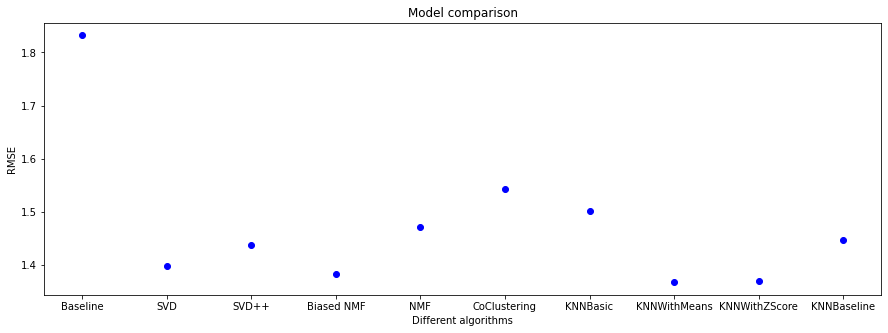

In [86]:
import matplotlib.pyplot as plt
RMSEs = [error_baseline,error_svd, error_svd_plus, error_nmfb, error_nmf, error_CoClustering,error_KNNBasic,error_KNNWithMeans,error_KNNWithZScore,error_KNNBaseline]
algorithms = ['Baseline','SVD', 'SVD++', "Biased NMF", 'NMF', 'CoClustering','KNNBasic','KNNWithMeans','KNNWithZScore','KNNBaseline']

plt.figure(figsize=(15,5))
plt.plot(algorithms, RMSEs,'bo' )
plt.xlabel("Different algorithms")
plt.ylabel("RMSE")
plt.title('Model comparison')
plt.show()


In [138]:
recommendations(1303,product_ids_true,model_KNNWithMeans)

[(22042, 3.715628162498193),
 (6999, 3.715628162498193),
 (5264, 3.715628162498193),
 (11357, 3.715628162498193),
 (5157, 3.715628162498193)]

# Content based recommender system


In [ ]:
data_new['combination'] = data_new['product_id'].apply(str) +' '+ data_new['product_category_name_english'] + ' ' + data_new['order_weekday']+ ' '+data_new['seller_state']+' '+data_new['order_month']+ ' ' +data_new['day_category']+' '+data_new['price_category']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
item_df = data_new[['customer_unique_id','combination']]

In [ ]:
item_df['combination'] = item_df['combination'].str.lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
item_df.head(10)

,customer_unique_id,combination
0,45758,17106 housewares monday sp oct morning low
50,54651,3315 housewares tuesday sp jan evening low
54,18828,27150 housewares monday sp aug evening low
95,18846,23621 housewares wednesday sp apr evening low
134,79270,24487 housewares tuesday sp mar afternoon low
158,11716,18498 housewares friday sp jun morning low
161,88725,18498 housewares thursday sp jun afternoon low
186,88725,18498 housewares thursday sp jul morning low
206,47768,18498 housewares saturday sp jun morning low
209,11716,18498 housewares wednesday sp may morning low


In [ ]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(item_df['combination'])

In [ ]:
count_matrix.shape

(9882, 5053)

In [ ]:
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [ ]:
metadata = item_df.reset_index()
#indices = pd.Series(metadata.index, index=metadata['title'])
metadata

,index,customer_unique_id,combination
0,0,45758,17106 housewares monday sp oct morning low
1,50,54651,3315 housewares tuesday sp jan evening low
2,54,18828,27150 housewares monday sp aug evening low
3,95,18846,23621 housewares wednesday sp apr evening low
4,134,79270,24487 housewares tuesday sp mar afternoon low
...,...,...,...
9877,111637,48527,32053 books_imported friday sp nov evening low
9878,111647,66013,13293 books_imported monday sp jul afternoon low
9879,111660,46303,16592 books_imported saturday sp apr afternoon...
9880,111676,34041,26630 la_cuisine wednesday sc nov afternoon low


In [ ]:
indices = pd.Series(metadata.index, index=metadata['customer_unique_id']).drop_duplicates()


In [ ]:
def get_recommendations(customer, cosine_sim=cosine_sim2):
    idx = indices[customer]
    #print(idx)

    sim_scores = list(enumerate(cosine_sim[idx]))
    #print(sim_scores)

    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    
    sim_scores = sim_scores[1:11]

    
    customer_indices = [i[0] for i in sim_scores]
    scores = [ i[1] for i in sim_scores]

    
    sim_products = metadata['combination'].iloc[customer_indices]
    sim_customers = metadata['customer_unique_id'].iloc[customer_indices]
    rec = {'customer': sim_customers, 'product': sim_products,'score':scores}
    return pd.DataFrame(data=rec)

In [ ]:
get_recommendations(18846, cosine_sim=cosine_sim2)

,customer,product,score
261,43512,15549 housewares wednesday sp apr evening low,0.857143
350,43512,6607 housewares wednesday sp apr evening low,0.857143
351,33576,16216 housewares wednesday sp apr evening low,0.857143
31,9138,19263 housewares wednesday sp feb evening low,0.714286
37,81178,8523 housewares wednesday sp jan evening low,0.714286
126,68642,31192 housewares friday sp apr evening low,0.714286
138,35733,14781 housewares wednesday sp jul evening low,0.714286
161,37172,6425 housewares wednesday sp apr morning low,0.714286
265,31703,21735 housewares friday sp apr evening low,0.714286
278,68772,31313 housewares wednesday sp jun evening low,0.714286
